In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

In [12]:
def target_function(x, y):
    """
    Función objetivo que combina múltiples mínimos locales con regiones
    de gradientes muy grandes (que pueden desestabilizar el entrenamiento)
    """
    # Base: función de Ackley modificada - conocida por ser difícil de optimizar
    # debido a sus numerosos mínimos locales y un gradiente casi plano
    a = 20
    b = 0.2
    c = 2 * np.pi
    
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    ackley = term1 + term2 + a + np.exp(1)
    
    # Añadir regiones con gradientes muy pronunciados (parte inestable)
    steep_region = 10 * np.tanh(5 * (x**2 + y**2 - 1.5)) + 5 * np.sin(10 * x * y)
    
    # Añadir picos altos y estrechos en ciertos puntos
    peaks = 8 * np.exp(-5 * ((x-0.7)**2 + (y+0.8)**2)) - 8 * np.exp(-5 * ((x+0.7)**2 + (y-0.8)**2))
    
    # Añadir valles irregulares adicionales
    valleys = 2 * np.sin(7 * x) * np.cos(7 * y) / (1 + 0.5 * (x**2 + y**2))
    
    # Combinar todo - normalizar para mantener los valores en un rango razonable
    result = (ackley / 10) + (steep_region / 5) + peaks + valleys
    
    return result

def generate_multimodal_dataset(n_samples=1000, noise_level=0.05):
    """Genera datos para la función multimodal"""
    print("Generando dataset con superficie multimodal...")
    
    # Generar puntos de entrada uniformemente distribuidos
    x = np.random.uniform(-2, 2, n_samples)
    y = np.random.uniform(-2, 2, n_samples)
    
    # Calcular valores objetivo
    z = np.array([target_function(x_i, y_i) for x_i, y_i in zip(x, y)])
    
    # Añadir ruido gaussiano
    z += np.random.normal(0, noise_level, n_samples)
    
    # Crear la matriz de características
    X = np.column_stack((x, y))
    
    print(f"Dataset generado: {X.shape} características, {z.shape} objetivos")
    return X, z

def visualize_target_function():
    """Visualiza la función objetivo en 3D"""
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Crear una malla de puntos para visualización
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = target_function(X[i, j], Y[i, j])
    
    # Graficar superficie
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    
    # Añadir colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Superficie de la Función Objetivo - Con Múltiples Valles y Regiones Inestables', fontsize=14)
    
    plt.savefig('target_function_3d.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # También mostrar un contour plot para visualizar mejor los valles
    plt.figure(figsize=(12, 10))
    cp = plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.colorbar(cp)
    plt.title('Contorno de la Función Objetivo - Observe los Múltiples Valles y Regiones Abruptas', fontsize=14)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    
    # Añadir anotaciones para destacar regiones problemáticas
    plt.annotate('Región con gradientes\nmuy pronunciados', xy=(0.6, 0.8), xytext=(1.0, 1.5),
                arrowprops=dict(facecolor='red', shrink=0.05, width=2), fontsize=12)
    
    plt.annotate('Mínimo local', xy=(-0.8, -0.7), xytext=(-1.5, -1.5),
                arrowprops=dict(facecolor='blue', shrink=0.05, width=2), fontsize=12)
    
    plt.annotate('Pico estrecho', xy=(0.7, -0.8), xytext=(1.5, -1.5),
                arrowprops=dict(facecolor='green', shrink=0.05, width=2), fontsize=12)
    
    plt.savefig('target_function_contour.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Visualizar el gradiente
    dy, dx = np.gradient(Z)
    grad_magnitude = np.sqrt(dx**2 + dy**2)
    
    plt.figure(figsize=(12, 10))
    cp = plt.contourf(X, Y, grad_magnitude, 50, cmap='hot')
    plt.colorbar(cp)
    plt.title('Magnitud del Gradiente - Observe las Regiones con Gradientes Extremos', fontsize=14)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    
    # Añadir anotaciones para destacar regiones con gradientes extremos
    plt.annotate('Gradientes muy grandes\n(pueden causar explosión)', xy=(0.7, 0.8), xytext=(1.5, 1.5),
                arrowprops=dict(facecolor='yellow', shrink=0.05, width=2), fontsize=12)
    
    plt.annotate('Gradientes casi planos\n(progreso muy lento)', xy=(-0.5, -0.5), xytext=(-1.5, -1.0),
                arrowprops=dict(facecolor='cyan', shrink=0.05, width=2), fontsize=12)
    
    plt.savefig('target_function_gradient.png', dpi=300, bbox_inches='tight')
    plt.show()

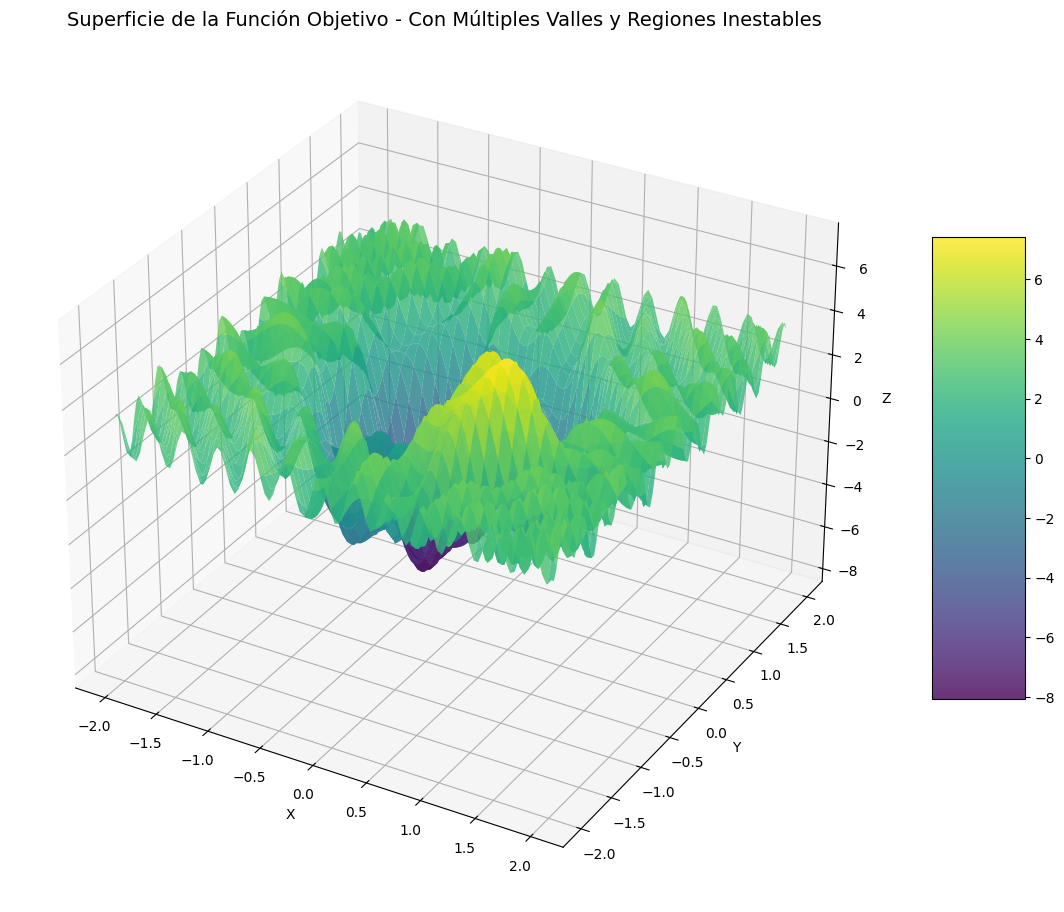

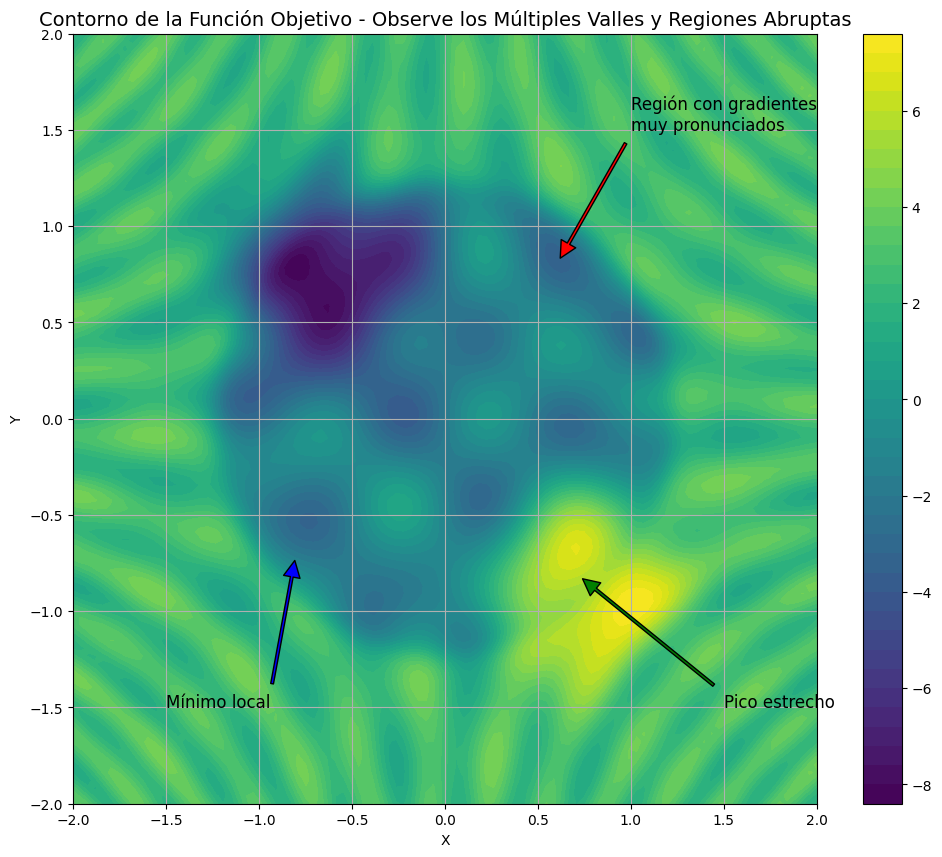

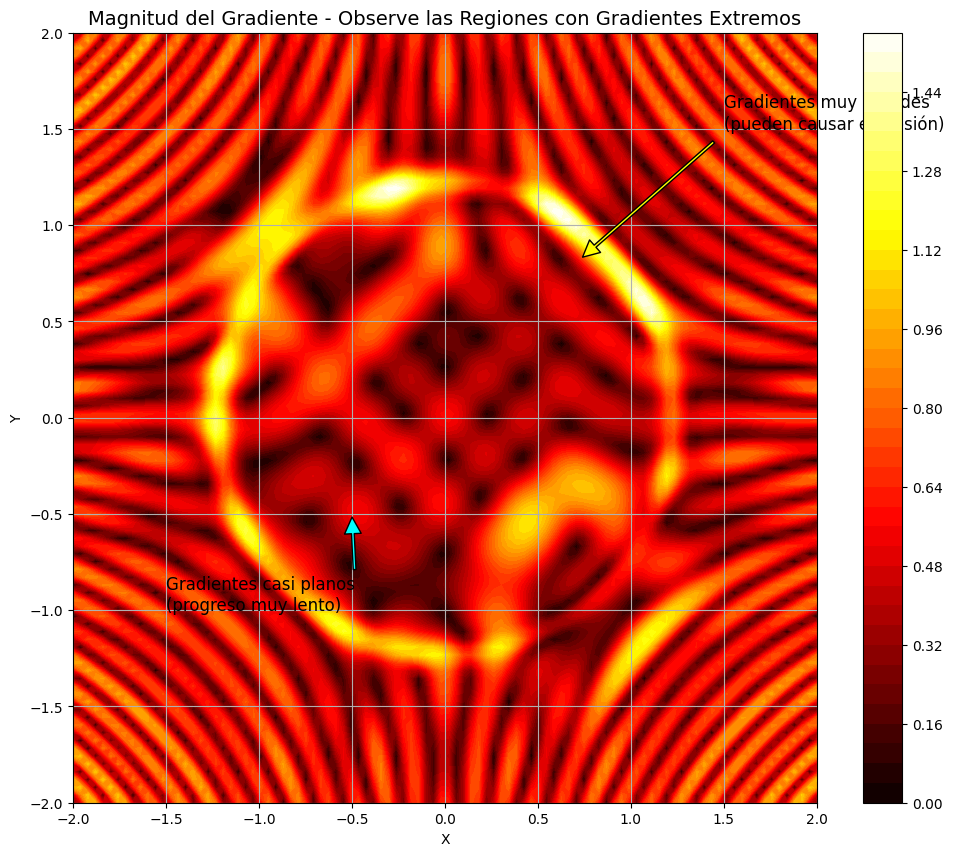

In [13]:
visualize_target_function()

In [14]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
    """
    Red neuronal para aproximar la función objetivo.
    """
    def __init__(self, input_size=2, hidden_sizes=[32, 64, 32], output_size=1):
        super(SimpleNet, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Primera capa
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Capas ocultas
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            
        # Capa de salida
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = torch.tanh(x)  # Tanh para permitir valores negativos
        
        # Capa final sin activación para regresión
        x = self.layers[-1](x)
        return x

In [15]:
from torch.utils.data import DataLoader, TensorDataset

def prepare_data(X, y, test_size=0.2, batch_size=32):
    """Prepara los datos para entrenamiento"""
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    n_train = n_samples - n_test
    
    # Dividir datos
    indices = np.random.permutation(n_samples)
    train_idx, test_idx = indices[:n_train], indices[n_train:]
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Convertir a tensores
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)
    
    # Crear DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

In [ ]:

def get_lr_scheduler(
        max_lr: float, 
        min_lr: float, 
        warmup_steps: int, 
        max_steps: int, 
        decay_type: str = 'cosine',
        final_div_factor: Optional[float] = None,
        verbose: bool = False
    ) -> Callable[[int], float]:
    """
    Create a learning rate scheduler with warmup and decay.
    
    Args:
        max_lr: Maximum learning rate after warmup
        min_lr: Minimum learning rate at the end of training
        warmup_steps: Number of steps for linear warmup
        max_steps: Total number of training steps
        decay_type: Type of decay schedule ('cosine', 'linear', 'exponential')
        final_div_factor: If provided, overrides min_lr to be max_lr / final_div_factor
        verbose: Whether to print validation messages
        
    Returns:
        Function that maps step number to learning rate
    
    Raises:
        ValueError: If any input parameter is invalid
    """
    # nada
    
    def get_lr(epoch: int, loss: float) -> float:
        """
        Calculate learning rate for a given step.
        
        Args:
            step: Current training step
            
        Returns:
            Learning rate for the step
        """
        # Toda la logica de como calcular lr
        
        return lr
        
    return get_lr


def predict_on_grid(model, grid_size=20):
    """Predice valores en una cuadrícula para visualización"""
    model.eval()
    x = np.linspace(-2, 2, grid_size)
    y = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    with torch.no_grad():
        for i in range(grid_size):
            for j in range(grid_size):
                inp = torch.FloatTensor([[X[i, j], Y[i, j]]])
                Z[i, j] = model(inp).item()
    
    return Z

def train_model(model, train_loader, val_data, criterion, learning_rate, epochs=200, 
             clip_value=None, scheduler_type='step', scheduler_params=None):
    """
    Entrena el modelo con una tasa de aprendizaje ajustable mediante scheduler
    Opcionalmente aplica gradient clipping para lidiar con gradientes explosivos
    
    Parámetros:
    - scheduler_type: 'step', 'cosine', 'plateau', 'exponential', o None
    - scheduler_params: diccionario con parámetros específicos del scheduler
    """
    X_val, y_val = val_data
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Configurar scheduler
    if scheduler_params is None:
        scheduler_params = {}
        
    if scheduler_type == 'step':
        step_size = scheduler_params.get('step_size', 30)
        gamma = scheduler_params.get('gamma', 0.1)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == 'cosine':
        T_max = scheduler_params.get('T_max', epochs)
        eta_min = scheduler_params.get('eta_min', 0)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    elif scheduler_type == 'plateau':
        patience = scheduler_params.get('patience', 10)
        factor = scheduler_params.get('factor', 0.1)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, 
                                                         patience=patience, verbose=True)
    elif scheduler_type == 'exponential':
        gamma = scheduler_params.get('gamma', 0.95)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == 'custom':
        scheduler = get_lr_scheduler(**scheduler_params)
    else:
        scheduler = None
    
    train_losses = []
    val_losses = []
    learning_rates = []
    
    # Para seguimiento de la trayectoria de optimización
    pred_trajectory = []
    gradient_norms = []
    
    # Predicción inicial en una cuadrícula para visualización
    pred_grid = predict_on_grid(model, 20)
    pred_trajectory.append(pred_grid)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        epoch_grad_norm = 0.0
        n_batches = 0
        
        # Steps:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Calculamos la norma del gradiente para monitorear inestabilidades
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            epoch_grad_norm += total_norm
            
            # Aplicar gradient clipping si se especifica
            if clip_value:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()
            
            running_loss += loss.item()
            n_batches += 1
        
        # Calcular pérdida promedio y norma promedio del gradiente
        epoch_train_loss = running_loss / n_batches
        epoch_grad_norm = epoch_grad_norm / n_batches
        
        train_losses.append(epoch_train_loss)
        gradient_norms.append(epoch_grad_norm)
        
        # Guardar el learning rate actual
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Evaluar en conjunto de validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_losses.append(val_loss)
        
        # Actualizar scheduler si es ReduceLROnPlateau
        if scheduler_type == 'plateau':
            scheduler.step(val_loss)
        # Actualizar otros tipos de scheduler
        if scheduler_type == 'custom':
            try:
                new_lr = scheduler(epoch)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr
                current_lr = new_lr
            except Exception as e:
                print(f"Error al actualizar learning rate: {e}")
            
        elif scheduler is not None:
            scheduler.step()
        
        # Guardar trayectoria cada 10 épocas
        if epoch % 10 == 0:
            # Predecir en cuadrícula para visualización
            pred_grid = predict_on_grid(model, 20)
            pred_trajectory.append(pred_grid)
            
        # Imprimir progreso cada 20 épocas
        if (epoch + 1) % 20 == 0:
            print(f'Época {epoch+1}/{epochs}, Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'LR: {current_lr:.6f}, Grad Norm: {epoch_grad_norm:.4f}')
        
        # Detectar divergencia (valores NaN o infinitos)
        if np.isnan(epoch_train_loss) or np.isinf(epoch_train_loss) or epoch_train_loss > 1e6:
            print(f"Entrenamiento divergente detectado en época {epoch+1}. Deteniendo entrenamiento.")
            # Agregar valores constantes grandes para el resto de épocas para visualización
            for _ in range(epoch+1, epochs):
                train_losses.append(train_losses[-1])
                val_losses.append(val_losses[-1])
                gradient_norms.append(gradient_norms[-1])
                learning_rates.append(learning_rates[-1])
            break
    
    training_time = time.time() - start_time
    print(f'Entrenamiento completado en {training_time:.2f} segundos')
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'training_time': training_time,
        'gradient_norms': gradient_norms,
        'learning_rates': learning_rates,
        'pred_trajectory': pred_trajectory
    }
    
def compare_learning_rates(X, y, lr_values=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1], epochs=200, batch_size=32, use_clipping=False):
    """Compara diferentes tasas de aprendizaje fijas"""
    # Preparar datos
    train_loader, test_loader, X_train, y_train, X_test, y_test = prepare_data(X, y, batch_size=batch_size)
    
    results = {}
    criterion = nn.MSELoss()
    
    for lr in lr_values:
        print(f"\n--- Entrenando con learning rate: {lr} ---")
        
        # Crear modelo con la misma inicialización para comparación justa
        torch.manual_seed(42)
        model = SimpleNet()
        
        # Entrenar modelo, con o sin gradient clipping
        clip_value = 1.0 if use_clipping else None
        result = train_model(
            model, 
            train_loader, 
            (X_test, y_test), 
            criterion, 
            learning_rate=lr,
            epochs=epochs,
            clip_value=clip_value,
            scheduler_type='cosine',
            scheduler_params={'T_max': epochs, 'eta_min': lr * 0.1}
        )
        
        # Evaluar en conjunto de prueba si el entrenamiento no divergió
        model.eval()
        try:
            with torch.no_grad():
                test_outputs = model(X_test)
                if torch.isnan(test_outputs).any() or torch.isinf(test_outputs).any():
                    print(f"Modelo con LR={lr} produjo predicciones inválidas (NaN/Inf)")
                    test_loss = float('nan')
                else:
                    test_loss = criterion(test_outputs, y_test).item()
                    print(f"MSE final en test: {test_loss:.4f}")
                result['test_mse'] = test_loss
                
                # Generar predicciones en una cuadrícula para visualizar superficie aprendida
                try:
                    pred_grid = predict_on_grid(model)
                    result['final_predictions'] = pred_grid
                except:
                    print(f"No se pudo generar cuadrícula de predicciones para LR={lr}")
                    result['final_predictions'] = None
        except:
            print(f"Error al evaluar modelo con LR={lr}, probablemente divergió")
            result['test_mse'] = float('nan')
            result['final_predictions'] = None
        
        # Almacenar modelo y resultados
        result['model'] = model
        results[lr] = result
    
    return results

def visualize_predictions(results, lr_values):
    """Visualiza las predicciones finales de cada modelo con diferente learning rate"""
    # Crear la cuadrícula de puntos reales
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    X, Y = np.meshgrid(x, y)
    Z_true = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z_true[i, j] = target_function(X[i, j], Y[i, j])
    
    # Filtrar learning rates con predicciones válidas
    valid_lrs = [lr for lr in lr_values if results[lr]['final_predictions'] is not None]
    
    if len(valid_lrs) == 0:
        print("Ningún modelo produjo predicciones válidas para visualizar.")
        return
    
    # Graficar superficie real y predicciones
    fig = plt.figure(figsize=(18, 12))
    
    # Superficie verdadera
    ax1 = fig.add_subplot(231, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_true, cmap='viridis', alpha=0.8)
    ax1.set_title('Superficie Real', fontsize=12)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Predicciones para cada learning rate
    for i, lr in enumerate(valid_lrs[:5]):  # Mostrar hasta 5 learning rates
        if i >= 5:
            break
            
        ax = fig.add_subplot(232 + i, projection='3d')
        
        # Obtener predicciones del grid
        Z_pred = results[lr]['final_predictions']
        
        # Redimensionar si es necesario
        if Z_pred.shape[0] != X.shape[0]:
            from scipy.interpolate import griddata
            grid_x, grid_y = np.mgrid[-2:2:Z_pred.shape[0]*1j, -2:2:Z_pred.shape[1]*1j]
            points = np.column_stack((grid_x.flatten(), grid_y.flatten()))
            values = Z_pred.flatten()
            Z_pred_interp = griddata(points, values, (X, Y), method='cubic')
            Z_pred = Z_pred_interp
        
        surf = ax.plot_surface(X, Y, Z_pred, cmap='plasma', alpha=0.8)
        ax.set_title(f'Predicción con LR={lr}', fontsize=12)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    plt.tight_layout()
    plt.savefig('prediction_comparison_3d.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Graficar curvas de entrenamiento y normas de gradiente
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for lr in lr_values:
        train_losses = np.array(results[lr]['train_losses'])
        # Limitar el rango para mejor visualización
        train_losses = np.clip(train_losses, 0, 10)
        plt.plot(train_losses, label=f'LR={lr}')
    plt.title('Pérdida de Entrenamiento (limitada a [0,10])', fontsize=12)
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    for lr in lr_values:
        val_losses = np.array(results[lr]['val_losses'])
        # Limitar el rango para mejor visualización
        val_losses = np.clip(val_losses, 0, 10)
        plt.plot(val_losses, label=f'LR={lr}')
    plt.title('Pérdida de Validación (limitada a [0,10])', fontsize=12)
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    for lr in lr_values:
        grad_norms = np.array(results[lr]['gradient_norms'])
        # Limitar el rango para mejor visualización
        grad_norms = np.clip(grad_norms, 0, 20)
        plt.plot(grad_norms, label=f'LR={lr}')
    plt.title('Norma del Gradiente (limitada a [0,20])', fontsize=12)
    plt.xlabel('Épocas')
    plt.ylabel('L2 Norm')
    plt.legend()
    plt.grid(True)
    
    # Gráfico de barras del error final
    plt.subplot(2, 2, 4)
    test_errors = [results[lr]['test_mse'] for lr in lr_values]
    # Reemplazar NaN por un valor grande para visualización
    test_errors = [10 if np.isnan(err) else min(err, 10) for err in test_errors]
    
    plt.bar(range(len(lr_values)), test_errors, color='skyblue')
    plt.xticks(range(len(lr_values)), [f'LR={lr}' for lr in lr_values], rotation=45)
    plt.ylabel('MSE en Test (limitado a 10)')
    plt.title('Error Final por Learning Rate', fontsize=12)
    
    for i, v in enumerate(test_errors):
        if v == 10:
            plt.text(i, v - 1, "Divergió", ha='center', color='red', fontweight='bold')
        else:
            plt.text(i, v + 0.5, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
def compare_with_without_clipping(X, y, lr_values=[1e-3, 1e-2, 5e-2], epochs=200, batch_size=32):
    """Compara entrenamiento con y sin gradient clipping para diferentes learning rates"""
    print("\n=== Entrenamiento SIN Gradient Clipping ===")
    results_no_clip = compare_learning_rates(X, y, lr_values, epochs, batch_size, use_clipping=False)
    
    print("\n=== Entrenamiento CON Gradient Clipping ===")
    results_with_clip = compare_learning_rates(X, y, lr_values, epochs, batch_size, use_clipping=True)
    
    # Visualizar comparación de pérdidas
    plt.figure(figsize=(15, 10))
    
    for i, lr in enumerate(lr_values):
        plt.subplot(len(lr_values), 2, 2*i+1)
        
        # Pérdida de entrenamiento sin clipping
        train_losses_no_clip = np.array(results_no_clip[lr]['train_losses'])
        train_losses_no_clip = np.clip(train_losses_no_clip, 0, 10)
        plt.plot(train_losses_no_clip, label='Sin Clipping', color='red')
        
        # Pérdida de entrenamiento con clipping
        train_losses_with_clip = np.array(results_with_clip[lr]['train_losses'])
        train_losses_with_clip = np.clip(train_losses_with_clip, 0, 10)
        plt.plot(train_losses_with_clip, label='Con Clipping', color='blue')
        
        plt.title(f'Pérdida de Entrenamiento (LR={lr})', fontsize=10)
        plt.xlabel('Épocas')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(len(lr_values), 2, 2*i+2)
        
        # Norma del gradiente sin clipping
        grad_norms_no_clip = np.array(results_no_clip[lr]['gradient_norms'])
        grad_norms_no_clip = np.clip(grad_norms_no_clip, 0, 20)
        plt.plot(grad_norms_no_clip, label='Sin Clipping', color='red')
        
        # Norma del gradiente con clipping
        grad_norms_with_clip = np.array(results_with_clip[lr]['gradient_norms'])
        grad_norms_with_clip = np.clip(grad_norms_with_clip, 0, 20)
        plt.plot(grad_norms_with_clip, label='Con Clipping', color='blue')
        
        plt.title(f'Norma del Gradiente (LR={lr})', fontsize=10)
        plt.xlabel('Épocas')
        plt.ylabel('L2 Norm')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('clipping_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_no_clip, results_with_clip

Generando dataset con superficie multimodal...
Dataset generado: (3000, 2) características, (3000,) objetivos

--- Entrenando con learning rate: 0.01 ---
Época 20/500, Loss: 0.7272, Val Loss: 0.6388, LR: 0.009968, Grad Norm: 3.1197
Época 40/500, Loss: 0.5561, Val Loss: 0.5192, LR: 0.009866, Grad Norm: 2.5540
Época 60/500, Loss: 0.4554, Val Loss: 0.4918, LR: 0.009694, Grad Norm: 1.9468
Época 80/500, Loss: 0.4379, Val Loss: 0.5812, LR: 0.009457, Grad Norm: 2.0057
Época 100/500, Loss: 0.3809, Val Loss: 0.4363, LR: 0.009157, Grad Norm: 1.6140
Época 120/500, Loss: 0.3649, Val Loss: 0.4004, LR: 0.008800, Grad Norm: 1.6177
Época 140/500, Loss: 0.4209, Val Loss: 0.4151, LR: 0.008390, Grad Norm: 2.4125
Época 160/500, Loss: 0.3360, Val Loss: 0.4126, LR: 0.007935, Grad Norm: 1.6507
Época 180/500, Loss: 0.3117, Val Loss: 0.3621, LR: 0.007442, Grad Norm: 1.5693
Época 200/500, Loss: 0.2977, Val Loss: 0.3470, LR: 0.006917, Grad Norm: 1.4473
Época 220/500, Loss: 0.2713, Val Loss: 0.3309, LR: 0.006371,

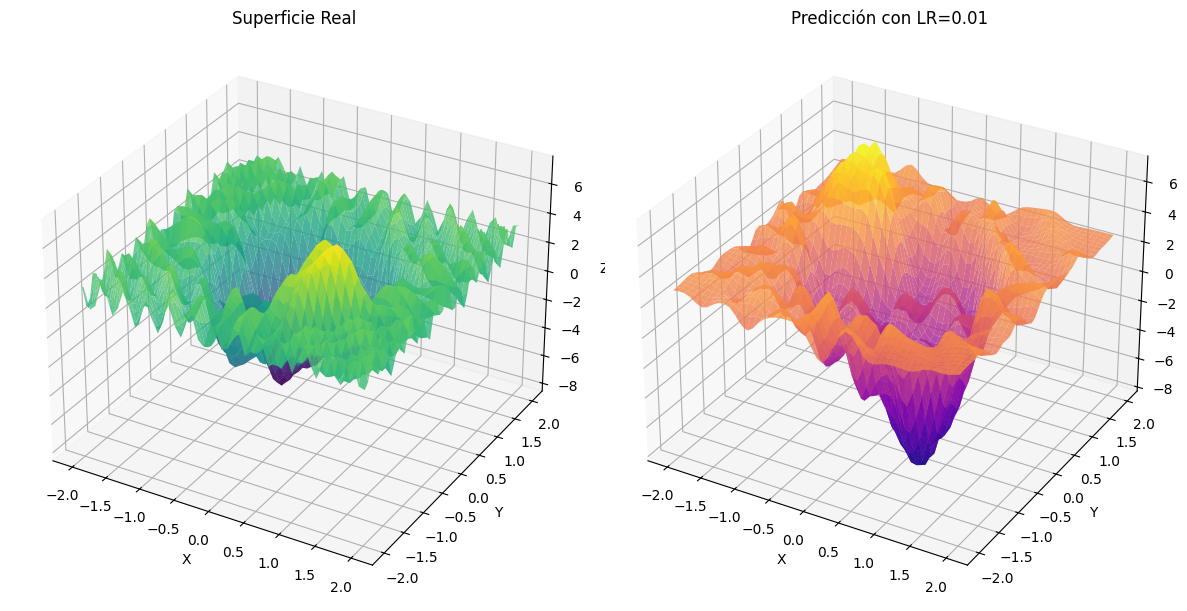

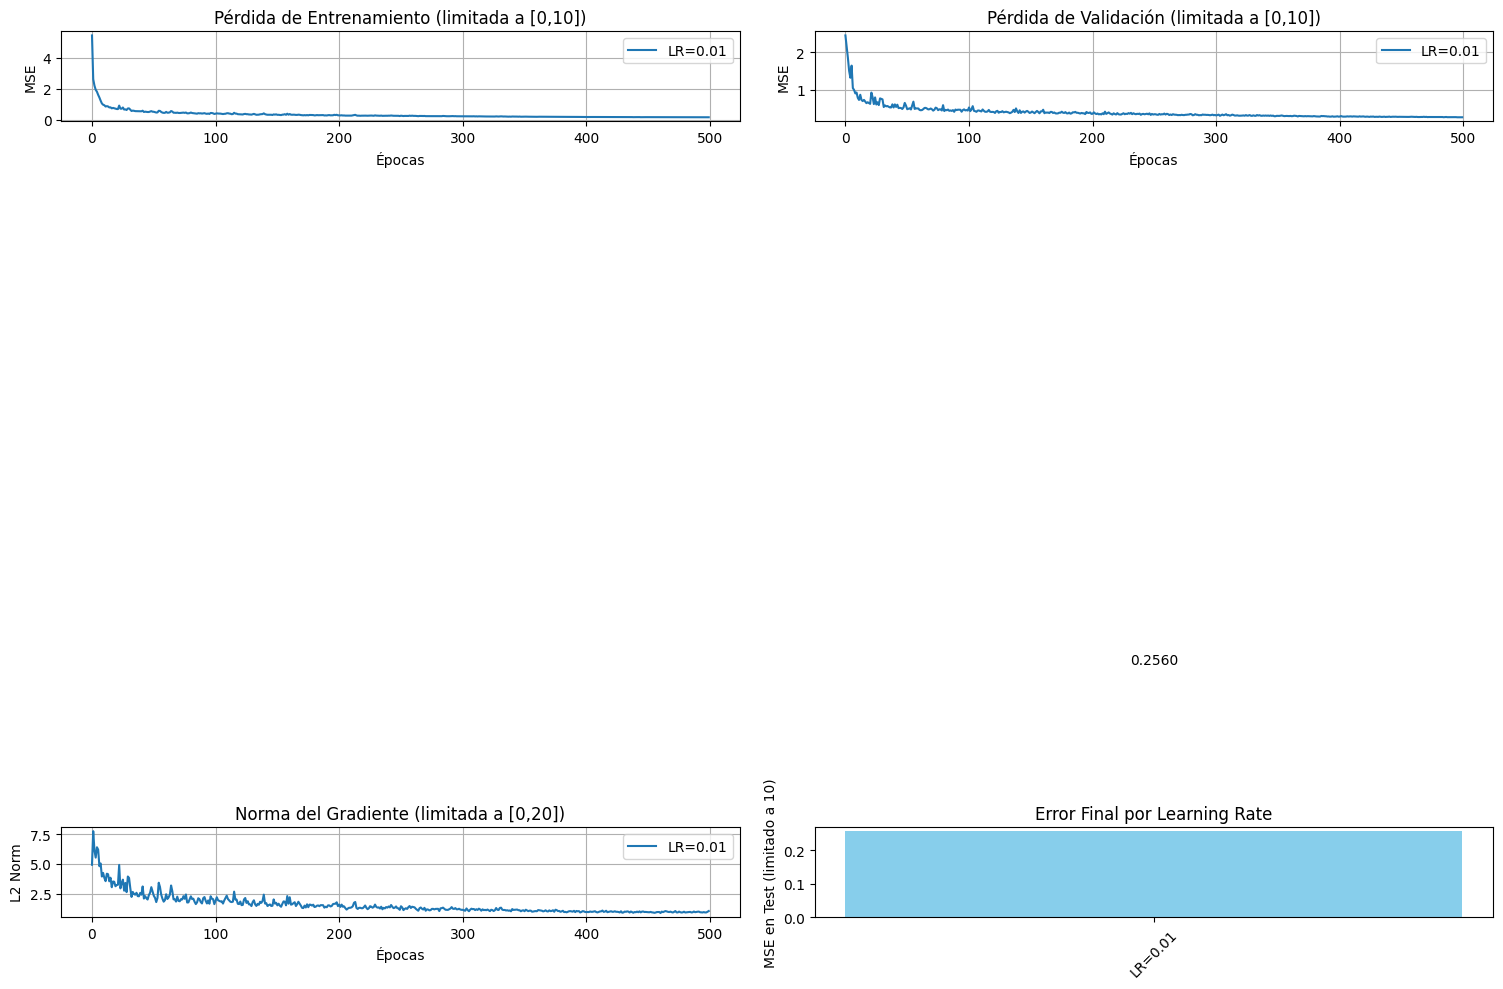


=== Entrenamiento SIN Gradient Clipping ===

--- Entrenando con learning rate: 0.01 ---
Época 20/500, Loss: 0.7958, Val Loss: 0.7302, LR: 0.009968, Grad Norm: 3.5800
Época 40/500, Loss: 0.5024, Val Loss: 0.5329, LR: 0.009866, Grad Norm: 2.0207
Época 60/500, Loss: 0.5394, Val Loss: 0.5329, LR: 0.009694, Grad Norm: 2.7221
Época 80/500, Loss: 0.4308, Val Loss: 0.3903, LR: 0.009457, Grad Norm: 1.8238
Época 100/500, Loss: 0.3980, Val Loss: 0.4140, LR: 0.009157, Grad Norm: 1.7555
Época 120/500, Loss: 0.3742, Val Loss: 0.3637, LR: 0.008800, Grad Norm: 1.5829
Época 140/500, Loss: 0.4299, Val Loss: 0.3717, LR: 0.008390, Grad Norm: 2.1346
Época 160/500, Loss: 0.3323, Val Loss: 0.3607, LR: 0.007935, Grad Norm: 1.6736
Época 180/500, Loss: 0.3027, Val Loss: 0.3284, LR: 0.007442, Grad Norm: 1.4585
Época 200/500, Loss: 0.3036, Val Loss: 0.3337, LR: 0.006917, Grad Norm: 1.6796
Época 220/500, Loss: 0.2731, Val Loss: 0.3130, LR: 0.006371, Grad Norm: 1.3948
Época 240/500, Loss: 0.2580, Val Loss: 0.2656,

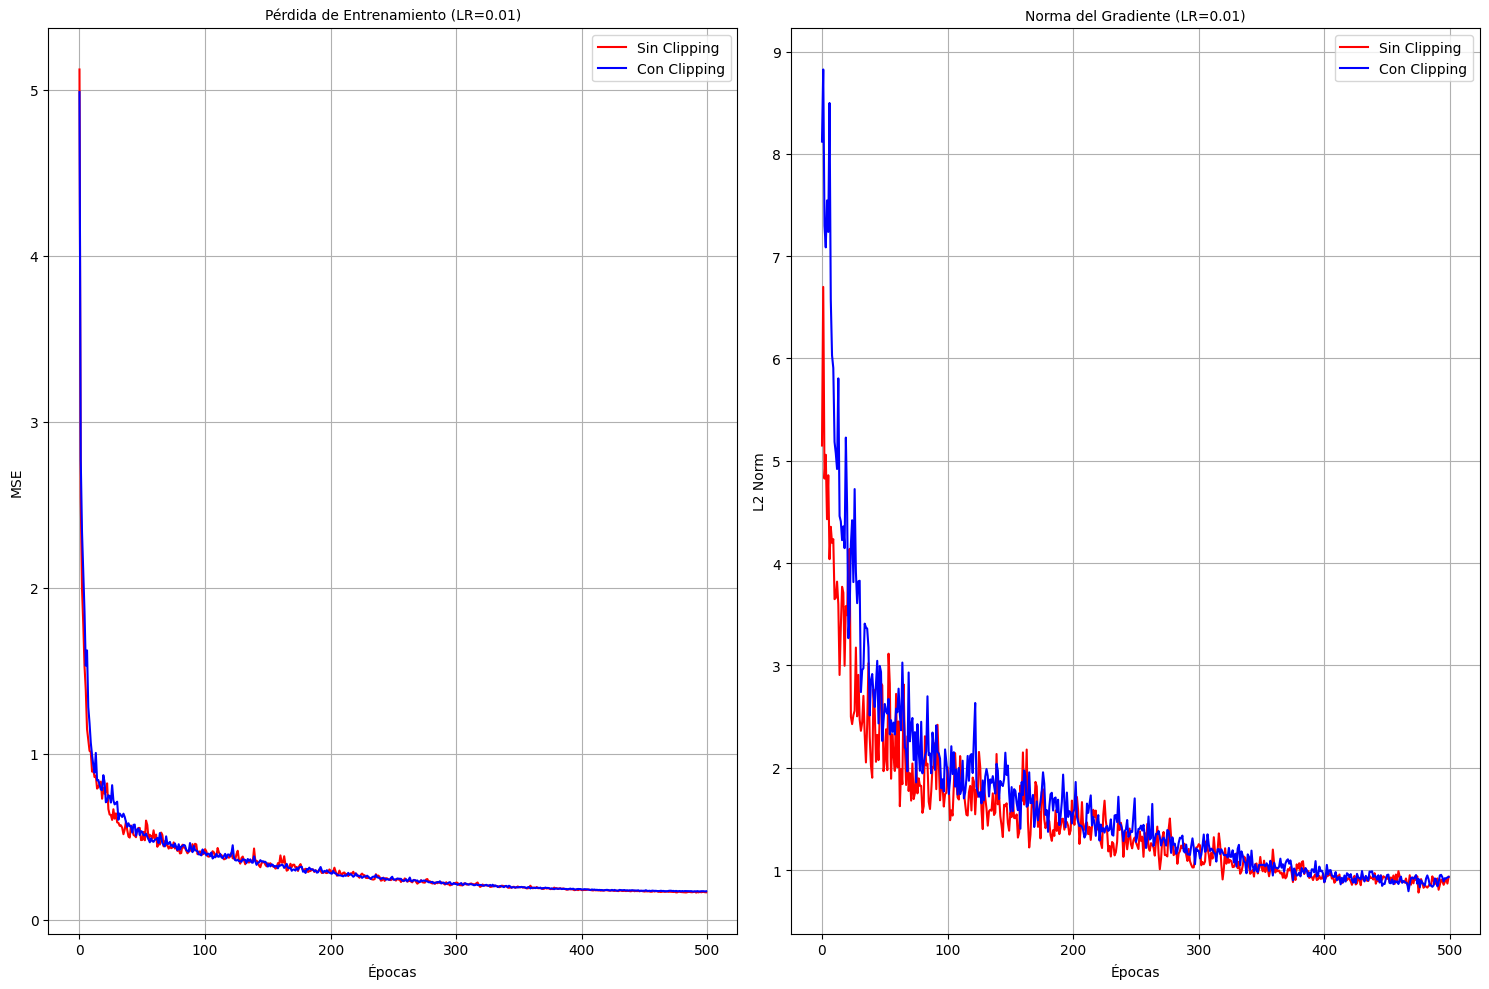

In [24]:
# Generar datos
X, y = generate_multimodal_dataset(n_samples=3000, noise_level=0.05)

# Comparar diferentes learning rates
lr_values = [1e-2]
results = compare_learning_rates(X, y, lr_values, epochs=500, batch_size=64)

# Visualizar resultados
visualize_predictions(results, lr_values)

# Comparar con y sin gradient clipping
results_no_clip, results_with_clip = compare_with_without_clipping(
    X, y, lr_values=[1e-2], epochs=500, batch_size=64
)